<a href="https://colab.research.google.com/github/JovitorzZ/LSTM-GS/blob/main/GS_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EQUIPE:

*   João Vitor Pires da Silva RM: 556213
*   Alan de Souza Maximiano da Silva RM: 557088
*   Danilo Ramalho Silva RM: 555183




# 0. Importando as bibliotecas e o DataSet  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [6]:
# Carregar e processar o dataset
df = pd.read_csv("/content/consumo_eletrico_brasil.csv")

#1. Tratamento dos dados e Análise Exploratória

In [9]:
#Filtrando apenas por tipo de consumo residencial
df_residencial = df[df['tipo_consumo'] == 'Residencial']

In [10]:
df_residencial.shape

(6480, 6)

In [11]:
#Agregando por data (ano e mês)
df_brasil = df_residencial.groupby(['ano', 'mes']).agg({
    'consumo': 'sum',
    'numero_consumidores': 'sum'
}).reset_index()

In [12]:
df_brasil.head()

,ano,mes,consumo,numero_consumidores
0,2004,1,6780672,45430039.0
1,2004,2,6429231,45630098.0
2,2004,3,6600331,45874004.0
3,2004,4,6808996,46044907.0
4,2004,5,6477331,45965740.0


In [13]:
df_brasil['data'] = pd.to_datetime(dict(year=df_brasil['ano'], month=df_brasil['mes'], day=1))
df_brasil = df_brasil.set_index('data').drop(['ano', 'mes'], axis=1)

In [14]:
df_brasil.head()

,consumo,numero_consumidores
data,,
2004-01-01,6780672,45430039.0
2004-02-01,6429231,45630098.0
2004-03-01,6600331,45874004.0
2004-04-01,6808996,46044907.0
2004-05-01,6477331,45965740.0


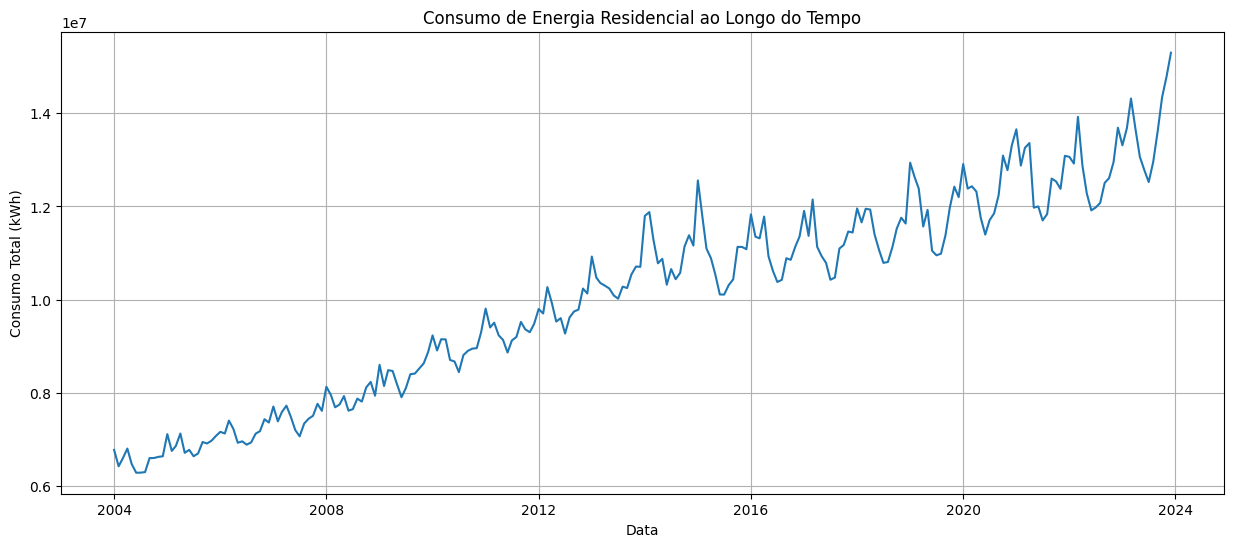

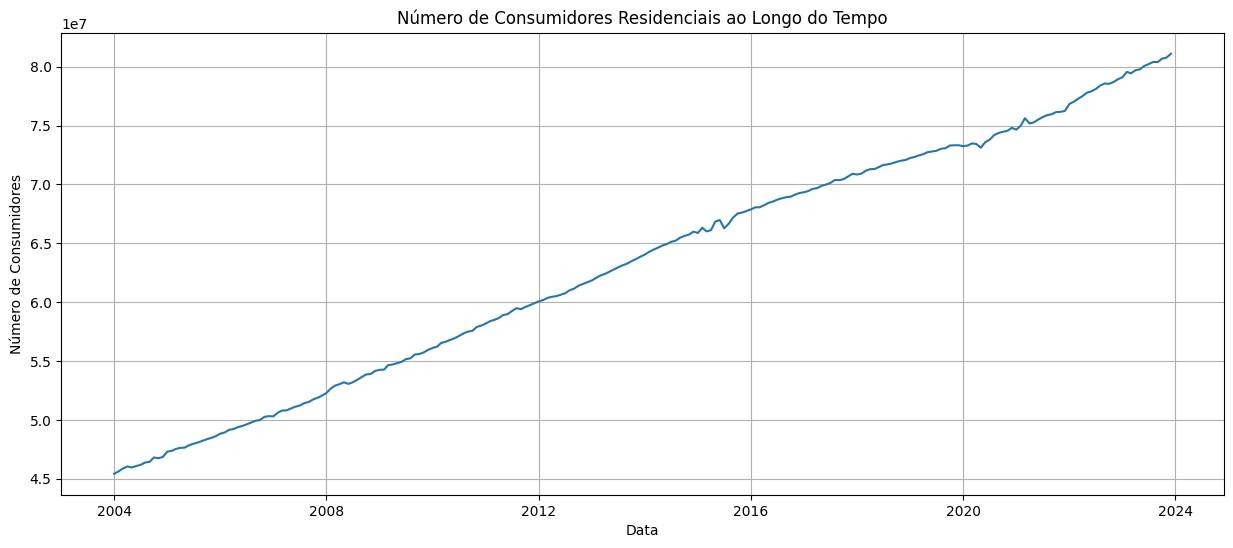

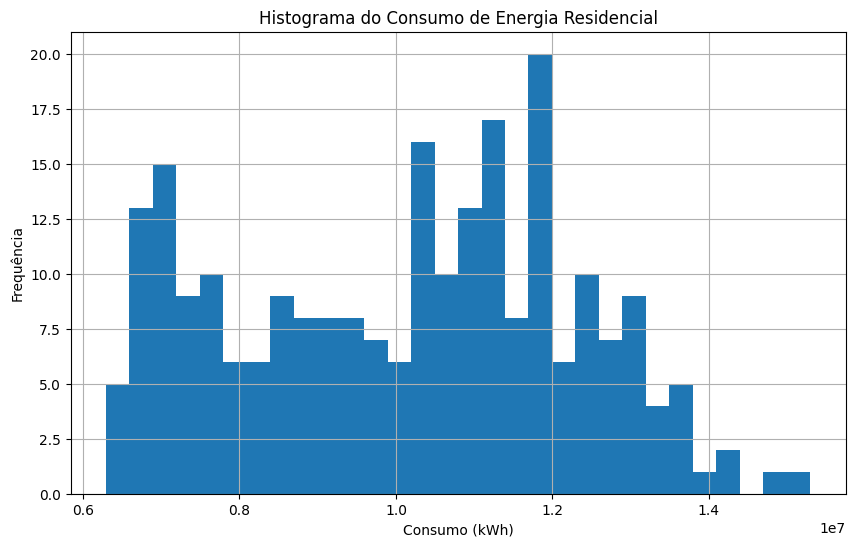

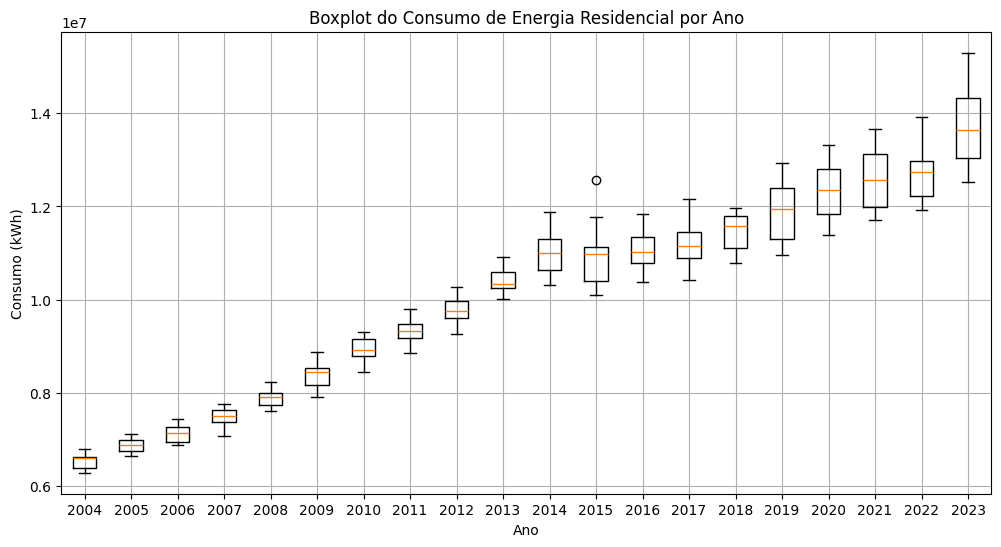

In [15]:
# Análise gráfica com matplotlib

plt.figure(figsize=(15, 6))
plt.plot(df_brasil['consumo'])
plt.title('Consumo de Energia Residencial ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo Total (kWh)')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(df_brasil['numero_consumidores'])
plt.title('Número de Consumidores Residenciais ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Consumidores')
plt.grid(True)
plt.show()

# Histograma do consumo
plt.figure(figsize=(10, 6))
plt.hist(df_brasil['consumo'], bins=30)
plt.title('Histograma do Consumo de Energia Residencial')
plt.xlabel('Consumo (kWh)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Boxplot do consumo por ano
plt.figure(figsize=(12, 6))
df_brasil['ano'] = df_brasil.index.year
plt.boxplot([df_brasil[df_brasil['ano'] == year]['consumo'] for year in df_brasil['ano'].unique()],
            labels=df_brasil['ano'].unique())
plt.title('Boxplot do Consumo de Energia Residencial por Ano')
plt.xlabel('Ano')
plt.ylabel('Consumo (kWh)')
plt.grid(True)
plt.show()

# 2.Pré-processamento dos dados

In [ ]:
#Normalizando os dados
scalers = {}
for column in ['consumo', 'numero_consumidores']:
    scaler = MinMaxScaler()
    df_brasil[column] = scaler.fit_transform(df_brasil[[column]])
    scalers[column] = scaler

In [ ]:
#Separando os dados em conjuntos de treino e teste
train_data, test_data = train_test_split(df_brasil, test_size=0.2, shuffle=False) #shuffle=False mantem a ordem temporal

In [ ]:
#Construir sequências temporais
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i][0]) # Consumo é a primeira coluna após set_index
    return np.array(X), np.array(y)

n_steps = 12
X_train, y_train = create_sequences(train_data.values, n_steps)
X_test, y_test = create_sequences(test_data.values, n_steps)


# 3. Construindo o modelo

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 2))) # input_shape=(n_steps, features) , return_sequences=False para apenas uma saída
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) # Ativação linear para regressão
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 4. Treinamento

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0870 - val_loss: 0.0065
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - val_loss: 0.0079
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.003

# 5. Avaliação do Modelo

In [ ]:
y_pred = model.predict(X_test)

#Invertendo a normalização para obter os valores reais de consumo
y_test_inv = scalers['consumo'].inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scalers['consumo'].inverse_transform(y_pred)


mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
MSE: 776116207723.8054
RMSE: 880974.5783641009


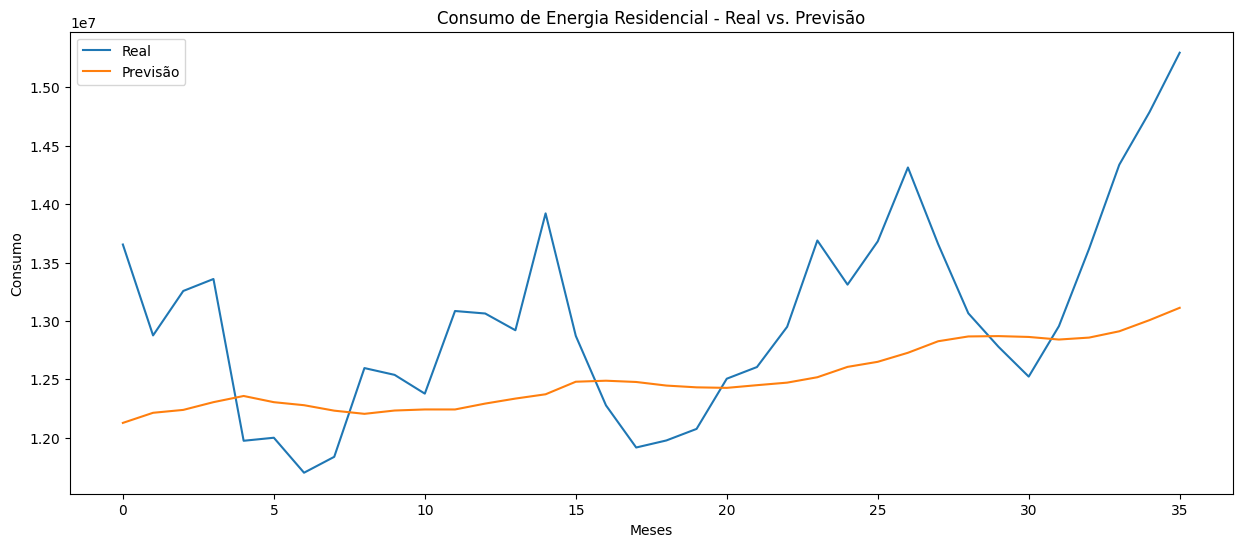

In [ ]:
# Gráfico comparando previsões com valores reais
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsão')
plt.title('Consumo de Energia Residencial - Real vs. Previsão')
plt.xlabel('Meses')
plt.ylabel('Consumo')
plt.legend()
plt.show()


# 6. Previsão para os próximos 12 meses

In [ ]:
#Usando o modelo treinado para prever o consumo dos próximos 12 meses
last_n_steps = test_data.tail(n_steps).values

future_predictions = []
for _ in range(12):
    next_pred = model.predict(last_n_steps.reshape(1, n_steps, 2))
    future_predictions.append(next_pred[0, 0])
    last_n_steps = np.append(last_n_steps[1:], [[next_pred[0,0], last_n_steps[-1][1]]], axis=0)


future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_inv = scalers['consumo'].inverse_transform(future_predictions)


#Criando datas para os próximos 12 meses
last_date = df_brasil.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='MS')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


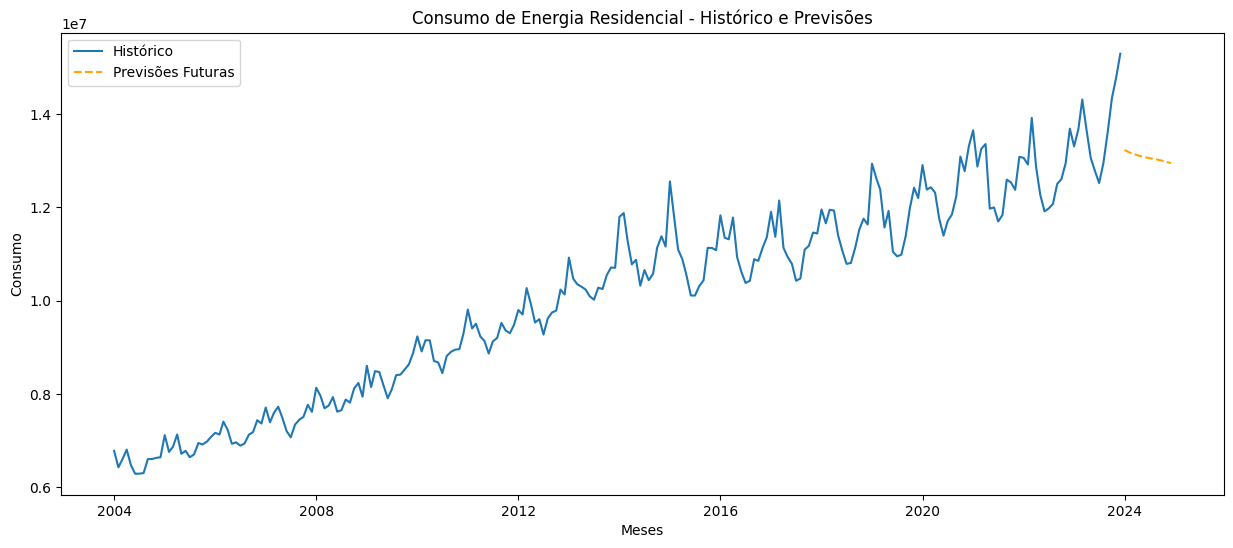

In [ ]:
plt.figure(figsize=(15, 6))

#Plotando o histórico de consumo (todos os dados de treino e teste)
plt.plot(df_brasil.index, scalers['consumo'].inverse_transform(df_brasil[['consumo']]), label='Histórico')

#Plotando as previsões futuras (em laranja tracejado)
plt.plot(future_dates, future_predictions_inv, label='Previsões Futuras', linestyle='--', color='orange')


plt.title('Consumo de Energia Residencial - Histórico e Previsões')
plt.xlabel('Meses')
plt.ylabel('Consumo')
plt.legend()
plt.show()

#7. Conclusão

1. **O modelo conseguiu capturar padrões no consumo de energia?**

Sim, o modelo conseguiu capturar padrões no consumo de energia residencial ao longo do tempo. Isso é evidenciado pela redução do erro durante o treinamento e validação. A utilização de uma arquitetura LSTM permitiu que o modelo aproveitasse dependências temporais nos dados para prever o consumo com base em séries temporais.

2.  **O quão preciso foi o modelo?**

Em geral, a precisão do modelo é moderada. Ele consegue capturar a tendência geral e a sazonalidade, o que é positivo. No entanto, a dificuldade em prever os picos de consumo e o RMSE relativamente alto (considerando que deve ser avaliado em relação à escala dos dados) indicam que as previsões podem não ser confiáveis o suficiente para aplicações críticas sem refinamentos adicionais. Ele serve como um bom ponto de partida, mas precisa de mais ajustes e possivelmente a inclusão de variáveis externas para melhorar sua capacidade preditiva.

3. **Sugestões de melhorias no modelo ou na preparação dos dados:**

Algumas melhorias podem ser:

* Aprimoramento da Arquitetura: Adicionar mais camadas LSTM ou unidades ocultas para capturar padrões mais complexos.

* Aumento do conjunto de dados: Adicionando mais dados históricos de consumo. Mais dados podem ajudar o modelo a aprender padrões mais complexos e melhorar a generalização.


